# **Laboratorio 6** - Algoritmos Genéticos

Angélica Ortiz - 202222480 <br>
María José Amorocho - 202220179

# 1. Problema 1: Corridor Crawler

In [ ]:
import random

def generate_population(size, genome_length):
    population = []
    for i in range(size):
        genome = [random.choice(['N', 'S', 'E', 'W']) for i in range(genome_length)]
        population.append(genome)
    return population

In [17]:
def reward(individual, maze, start, end):
    current_position = start
    steps = 0
    fitness = 0
    for move in individual:
        # Moverse en función del movimiento
        if move == 'N':
            new_position = (current_position[0] - 1, current_position[1])
        elif move == 'S':
            new_position = (current_position[0] + 1, current_position[1])
        elif move == 'E':
            new_position = (current_position[0], current_position[1] + 1)
        elif move == 'W':
            new_position = (current_position[0], current_position[1] - 1)
        
        # Comprobar si la nueva posición está dentro de los límites del laberinto
        if not (0 <= new_position[0] < len(maze) and 0 <= new_position[1] < len(maze[0])):
            fitness -= 10  # Penalización por moverse fuera de los límites
            continue  # Salir del bucle y no continuar con este movimiento
        
        # Comprobar si hay colisión
        if maze[new_position[0]][new_position[1]] == 1:  # Pared en la nueva posición
            fitness -= 10  # Penalización por colisión
            continue  # Salir del bucle y no continuar con este movimiento

        # Actualizar posición y pasos
        current_position = new_position
        steps += 1
        
        # Comprobar si alcanzó la salida
        if current_position == end:
            fitness += 100  # Bonificación por encontrar la salida
            break

    fitness -= steps  # Penalización por el número de pasos
    return fitness


In [3]:
def select(population, fitnesses):
    total_fitness = sum(fitnesses)
    probabilities = [fitness / total_fitness for fitness in fitnesses]
    
    selected = random.choices(population, probabilities, k=len(population))
    return selected


In [4]:
def crossover(parent1, parent2):
    # función de crossover utiulizando cruce de punto
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

In [ ]:
def mutate(individual, mutation_rate):
    #La mutación se realiza cambiando aleatoriamente uno de los movimientos en el cromosoma del individuo
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = random.choice(['N', 'S', 'E', 'W'])
    return individual

In [13]:
def apply_elitism(population, offspring_population, elitism_count, start, end, maze):
    sorted_population = sorted(population, key=lambda ind: reward(ind, maze, start, end), reverse=True)
    elitism = sorted_population[:elitism_count]
    offspring_population += elitism
    return sorted(offspring_population, key=lambda ind: reward(ind, maze, start, end), reverse=True)[:len(population)]

In [32]:
def evolve(population, maze, start, end, max_generations, crossover_rate, mutation_rate, elitism_count):
    generation = 0
    while generation < max_generations:
        print(f'generation: {generation}')
        fitnesses = [reward(individual, maze, start, end) for individual in population]
        print(f'fitnesses: {fitnesses}')
        # Selección
        mating_pool = select(population, fitnesses)
        
        # Cruce (Recombination)
        offspring_population = []
        for i in range(0, len(mating_pool) - elitism_count, 2):
            parent1, parent2 = mating_pool[i], mating_pool[i+1]
            if random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            offspring_population.append(child1)
            offspring_population.append(child2)
        
        # Mutación
        for individual in offspring_population:
            mutate(individual, mutation_rate)
        
        # Evaluación de aptitud
        fitnesses = [reward(individual, maze, start, end) for individual in offspring_population]
        print(f'fitnesses 2: {fitnesses}')
        # Aplicar elitismo
        population = apply_elitism(population, offspring_population, elitism_count, start, end, maze)
    
        generation += 1
    
    # Devolver el mejor individuo
    best_individual = max(population, key=lambda ind: reward(ind, maze, start, end))
    return best_individual


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import ListedColormap

def create_maze(dim):
    # Create a grid filled with walls (1)
    # Set the seed to ensure reproducibility
    np.random.seed(2)
    maze = np.ones((dim * 2 + 1, dim * 2 + 1), dtype=int)

    # Define the starting point
    x, y = (0, 0)
    maze[2 * x + 1, 2 * y + 1] = 0  # Mark start as open path

    # Initialize the stack with the starting point for DFS
    stack = [(x, y)]
    
    while stack:
        x, y = stack[-1]

        # Define possible directions (right, down, left, up)
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)  # Randomize order for more organic mazes

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            # Check if next cell is within bounds and is a wall
            if 0 <= nx < dim and 0 <= ny < dim and maze[2 * nx + 1, 2 * ny + 1] == 1:
                # Break wall to create path
                maze[2 * nx + 1, 2 * ny + 1] = 0
                maze[2 * x + 1 + dx, 2 * y + 1 + dy] = 0
                stack.append((nx, ny))  # Move to the next cell
                break
        else:
            stack.pop()  # Backtrack if no unvisited neighbors

    # Create entrance and exit points
    maze[1, 0] = 0  # Entrance
    maze[-2, -1] = 0  # Exit

    return maze

def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'black'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()


In [35]:
population_size = 5
max_generations = 5
crossover_rate = 0.5
mutation_rate = 0.01
elitism_count = 2

# Inicialización de población
population = generate_population(population_size, 30)

# Define the dimension of the maze (adjustable)
dim = 2 # This can be any positive integer
maze = create_maze(dim)
print(maze)

start = (1, 0)
end = (-2, -1)

# Ejecutar el algoritmo genético
best_individual = evolve(population, maze, start, end, max_generations, crossover_rate, mutation_rate, elitism_count)

print("Mejor individuo encontrado:", best_individual)

[[1 1 1 1 1]
 [0 0 0 0 1]
 [1 1 1 0 1]
 [1 0 0 0 0]
 [1 1 1 1 1]]
generation: 0
fitnesses: [-192, -183, -174, -165, -147]
fitnesses 2: [-174, -183, -165, -147]
generation: 1
fitnesses: [-147, -147, -165, -165, -174]
fitnesses 2: [-165, -165, -165, -147]
generation: 2
fitnesses: [-147, -147, -147, -165, -165]
fitnesses 2: [-147, -147, -183, -147]
generation: 3
fitnesses: [-147, -147, -147, -147, -147]
fitnesses 2: [-147, -147, -156, -147]
generation: 4
fitnesses: [-147, -147, -147, -147, -147]
fitnesses 2: [-147, -165, -147, -147]
Mejor individuo encontrado: ['S', 'E', 'E', 'N', 'N', 'S', 'S', 'E', 'S', 'N', 'W', 'W', 'W', 'W', 'S', 'E', 'E', 'E', 'S', 'S', 'W', 'N', 'E', 'W', 'S', 'S', 'W', 'N', 'S', 'N']


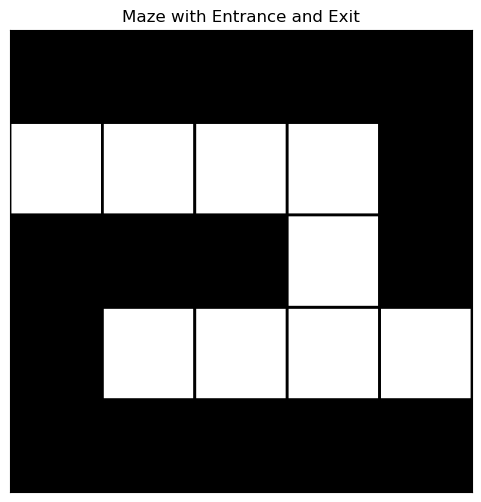

In [26]:
display_maze(maze)

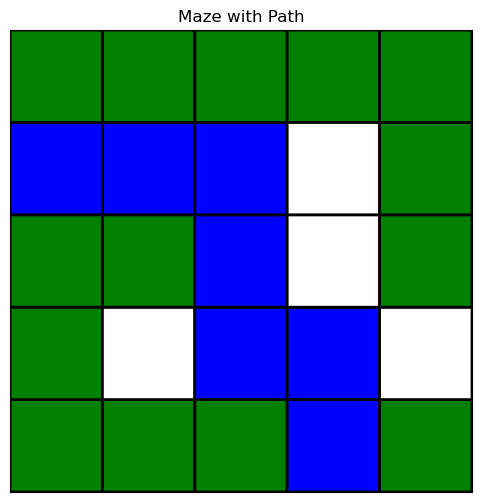

In [39]:
def display_maze2(maze, path=None):
    cmap = ListedColormap(['white', 'black', 'green', 'blue'])  # Azul para el camino recorrido
    plt.figure(figsize=(6, 6))
    
    # Si el robot ha recorrido un camino, dibujamos esas posiciones en azul
    maze_copy = maze.copy()  # Crear una copia del laberinto para modificar sin afectar el original
    
    if path:
        for (i, j) in path:
            maze_copy[i, j] = 2  # Usar valor 2 para marcar las posiciones recorridas
    
    # Mostrar el laberinto con las posiciones recorridas
    plt.pcolor(maze_copy[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Path')
    plt.show()

# Función para mostrar el camino del robot
def plot_robot_path(maze, start, path):
    current_position = start
    path_positions = [start]  # Empezamos con la posición inicial del robot
    
    # Moverse según la secuencia de movimientos
    for move in path:  # path es una secuencia de movimientos como ['N', 'E', 'S', 'W']
        if move == 'N':
            current_position = (current_position[0] - 1, current_position[1])
        elif move == 'S':
            current_position = (current_position[0] + 1, current_position[1])
        elif move == 'E':
            current_position = (current_position[0], current_position[1] + 1)
        elif move == 'W':
            current_position = (current_position[0], current_position[1] - 1)
        
        # Añadir la nueva posición al camino
        path_positions.append(current_position)
    
    # Mostrar el laberinto con el camino recorrido
    display_maze2(maze, path_positions)
    
path = ['E', 'E', 'S', 'S', 'E', 'S'] 
plot_robot_path(maze, start, path)